In [2]:
import pandas as pd
from pandas import Series
import numpy as np
import os
import pickle
import random
from collections import Counter
from operator import itemgetter
import joblib
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from scipy.stats import rankdata
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn import svm
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from rdkit import Chem
from rdkit.Chem.rdmolfiles import MolToSmiles, MolFromSmiles
from rdkit.Chem import Lipinski, Descriptors
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import tmap as tm
from faerun import Faerun
from map4 import MAP4Calculator

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
folder = "/data/NPAtlas/"

# 1. Properties Calculation
The December 2019 version of the [Natural Product Atlas](https://www.npatlas.org/joomla/) was downloaded. 
The MW and the compound origin were read from the downloaded data. 
HBA and HBD, cLogP, TPSA, and fraction of sp3 carbon were calculated using [RDKit](https://www.rdkit.org/). The boiling point was calculated using the open source code of the [JRgui](https://github.com/curieshicy/JRgui) as the Joback boiling temperature. 
The [MAP4 fingerprint](https://github.com/reymond-group/map4) was calculated in 1024 dimensions. 
Molecules that violated more than one Lipinski rules were labelled as non-Lipinski. 
To identify glycosylated and/or peptidic structures Daylight SMARTS language was used. 

In [3]:
frame = pd.read_csv(folder + 'np_atlas_2019_12.tsv', sep="\t")

In [4]:
MAP4 = MAP4Calculator(dimensions=1024)
def calc_map4(smiles):
    mol = Chem.MolFromSmiles(smiles)
    smiles = Chem.MolToSmiles(mol, isomericSmiles=False)
    mol = Chem.MolFromSmiles(smiles)
    map4 = MAP4.calculate(mol)
    return np.array(map4)

def calc_hba(smiles):
    mol = Chem.MolFromSmiles(smiles)
    hba = Lipinski.NumHAcceptors(mol)
    return hba

def calc_hbd(smiles):
    mol = Chem.MolFromSmiles(smiles)
    hbd = Lipinski.NumHDonors(mol)
    return hbd

def calc_fcsp3(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fcsp3 = Lipinski.FractionCSP3(mol)
    return fcsp3

def calc_logp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    logp = Descriptors.MolLogP(mol)
    return logp

def calc_tpsa(smiles):
    mol = Chem.MolFromSmiles(smiles)
    tpsa = Descriptors.TPSA(mol)
    return tpsa

def is_lipinski(row):
    rules = 0
    if row["Molecular Weight"] >= 500:
        rules += 1
    if row.HBA > 10:
        rules += 1
    if row.HBD > 5:
        rules += 1
    if row.cLogP > 5:
        rules += 1
    if rules > 1 :
        return 0
    else:
        return 1

def is_bacterium(origin):
    if origin == "Bacterium":
        return 1
    else:
        return 0

def create_label(row):
    smiles = row.SMILES
    NPAID = row.NPAID
    link = f'https://www.npatlas.org/joomla/index.php/explore/compounds#npaid={NPAID}'
    label = f'{smiles}__<a target="_blank" href={link}">{NPAID}</a>'
    #label = smiles+"__"+NPAID+"__"+link
    return label

def has_aminoacid(smiles):
    m = Chem.MolFromSmiles(smiles)
    # generic dipeptide (does not hit Pro)
    if m.HasSubstructMatch(Chem.MolFromSmarts('[NX3,NX4+][CH1,CH2][CX3](=[OX1])[NX3,NX4+][CH1,CH2][CX3](=[OX1])[O,N]')):
        return 1
    else:
        return 0
    
def has_sugar(smiles):
    m = Chem.MolFromSmiles(smiles)
    # acetal moiety
    if m.HasSubstructMatch(Chem.MolFromSmarts('[CR][OR][CHR]([OR0,NR0])[CR]')):
        return 1
    else:
        return 0
    
def sub_smarts(row):
    if row.hasSugar == 1 and row.isPeptide == 1:
        return 2
    elif row.hasSugar == 1:
        return 0
    elif row.isPeptide == 1:
        return 1
    else:
        return 3

from the JRgui program source code https://github.com/curieshicy/JRgui:

In [5]:
DB = [[0.0026,	0.0028,	36,	26.15,	17.78,	142.14,	136.70,	2.74E+1,	-5.57E-2,	1.01E-4,	-5.02E-8,	4.720,	2.661,	"NA",	"NA"],
            [0.0027,	-0.0008,46,	9.20,	-11.18,	79.30,	77.71,	2.45E+1,	-2.71E-2,	1.11E-4,	-6.78E-8,	2.322,	1.155,	"NA",	"NA"],
            [0.0020,	0.0016,	37,	27.38,	64.32,	115.51,	109.82,	7.87,	         2.01E-2,	-8.33E-6,	1.39E-9,	4.151,	3.302,	"NA",	"NA"],
            [0.0791,	0.0077,	89,	169.09,	155.50,	-426.72,-387.87,2.41E+1,	4.27E-2,	8.04E-5,       -6.87E-8,	11.051,	19.537,	1317.23,-2.578],
            [0.0481,	0.0005,	82,	81.10,	53.60,	-337.92,-301.95,2.45E+1,	4.02E-2,	4.02E-5,	-4.52E-8,	6.959,	9.633,	483.88,	-0.966],
            [0.0284,	0.0028,	55,	94.97,	75.97,	-164.50,-126.27,3.04E+1,	-8.29E-2,	2.36E-4,       -1.31E-7,	"NA",	6.645,	"NA",	"NA"],
            [0.0379,	0.0030,	82,	72.24,	36.90,	-162.03,-143.48,3.09E+1,	-3.36E-2,	1.60E-4,       -9.88E-8,	3.197,	9.093,	740.92,	-1.713],
            [0.0741,	0.0112,	28,	92.88,	44.45,	-208.04,-189.20,2.57E+1,	-6.91E-2,	1.77E-4,	-9.88E-8,	2.406,	16.826,	2173.72,-5.057],
            [0.0240,	0.0184,	-25,	76.34,	82.83,	-221.65,-197.37,-2.81,	         1.11E-1,	-1.16E-4,	4.94E-8,	4.490,	12.499,	3018.17,-7.314],
            [0.0098,	0.0048,	13,	31.22,	23.05,	-138.16,-98.22,	1.22E+1,	-1.26E-2,	6.03E-5,	-3.86E-8,	5.879,	4.682,	440.24,	-0.953],
            [0.0380,	0.0031,	62,	76.75,	61.20,	-133.22,-120.50,6.45,	         6.70E-2,	-3.57E-5,	2.86E-9,	4.189,	8.972,	340.35,	-0.350],
            [0.0168,	0.0015,	18,	22.42,	22.23,	-132.22,-105.00,2.55E+1,	-6.32E-2,	1.11E-4,       -5.48E-8,	1.188,	2.410,	122.09,	-0.386],
            [0.0437,	0.0064,	91,	152.54,	127.24,	-66.57,	-16.83,	2.59E+1,	-3.74E-3,	1.29E-4,	-8.88E-8,	9.679,	16.738,	"NA",	"NA"],
            [0.0143,	0.0101,	36,	-10.50,	2.08,	-247.61,-250.83,6.82,	        1.96E-2,	1.27E-5,	-1.78E-8,	3.624,	5.909,	675.24,	-1.340],
            [0.0085,	0.0076,	34,	57.55,	68.40,	55.52,	79.93,	8.83,	      -3.84E-3,	         4.35E-5,	-2.60E-8,	3.649,	6.528,	"NA",	"NA"],
            [0.0130,	0.0114,	29,	52.82,	101.51,	31.65,75.61,1.18E+1,	        -2.30E-2,	1.07E-4,	-6.28E-8,	7.490,	6.930,	"NA",	"NA"],
            ["NA",  	"NA",	"NA",	83.08,	68.91,	93.70,	119.66,	5.69,	       -4.12E-3,	1.28E-4,	-8.88E-8,	"NA",	12.169,	"NA",	"NA"],
            [0.0255,	-0.0099,"NA",	74.60,	"NA",	23.61,	"NA",     "NA",	         "NA",	         "NA",	          "NA", 	"NA",	3.335,	"NA",	"NA"],
            [0.0496,	-0.0101,91,	125.66,	59.89,	88.43,	89.22,	3.65E+1,	-7.33E-2,	1.84E-4,	-1.03E-7,	2.414,	12.851,	"NA",	"NA"],
            [0.0243,	0.0109,	38,	73.23,	66.89,	-2.02,	14.07,2.69E+1,	        -4.12E-2,	1.64E-4,        -9.76E-8,	3.515,	10.788,	"NA",	"NA"],
            [0.0295,	0.0077,	35,	50.17,	52.66,	53.47,	89.39,-1.21,	        7.62E-2,	-4.86E-5,	1.05E-8,	5.009,	6.436,	"NA",	"NA"],
            [0.0169,	0.0074,	9,	11.74,	48.84,	123.34,	163.16,-3.11E+1,	2.27E-1,	-3.20E-4,	1.46E-7,	4.703,	1.896,	"NA",	"NA"],
            [0.0031,	0.0084,	63,	63.56,	20.09,	-17.33,	-22.99,	3.53E+1,	-7.58E-2,	1.85E-4,	-1.03E-7,	2.360,	6.884,	"NA",	"NA"],
            [0.0119,	0.0049,	54,	68.78,	34.40,	41.87,	33.12,	1.96E+1,	-5.61E-3,	4.02E-5,	-2.76E-8,	4.130,	6.817,	"NA",	"NA"],
            [0.0019,	0.0051,	38,	52.10,	79.93,	39.10,	27.76,	1.67E+1,	4.81E-3,	2.77E-5,	-2.11E-8,	1.557,	5.984,	"NA",	"NA"],
            [0.0082,	0.0011,	41,	26.73,	8.13,	2.09,	11.30,	-2.14,	        5.74E-2,	-1.64E-6,	-1.59E-8,	1.101,	2.544,	259.65,	-0.702],
            [0.0143,	0.0008,	32,	31.01,	37.02,	46.43,	54.05,	-8.25,	        1.01E-1,	-1.42E-4,	6.78E-8,	2.394,	3.059,	-245.74,0.912],
            [0.0100,	0.0025,	48,	27.15,	7.75,	-26.80,	-3.68,	-6.03,	         8.54E-2,	-8.00E-6,	-1.80E-8,	0.490,	2.398,	307.53,	-0.798],
            [0.0122,	0.0004,	38,	21.78,	19.88,	8.67,	40.99,	-2.05E+1,	1.62E-1,	-1.60E-4,	6.24E-8,	3.243,	1.942,	-394.29,1.251],
            [0.0042,	0.0061,	27,	21.32,	60.15,	79.72,	87.88,	-9.09E+1,	5.57E-1,	-9.00E-4,	4.69E-7,	-1.373,	0.644,	"NA",	"NA"],
            [0.0113,	-0.0028,56,	18.18,	-4.32,	-9.630,	3.77,	2.36E+1,	-3.81E-2,	1.72E-4,	-1.03E-7,	-0.473,	1.724,	495.01,	-1.539],
            [0.0129,	-0.0006,46,	24.96,	8.73,	37.97,	48.53,	-8.00,	        1.05E-1,	-9.63E-5,	3.56E-8,	2.691,	2.205,	82.28,	-0.242],
            [0.0117,	0.0011,	38,	24.14,	11.14,	83.99,	92.36,	-2.81E+1,	2.08E-1,	-3.06E-4,	1.46E-7,	3.063,	2.138,	"NA",	"NA"],
            [0.0141,	-0.0012,65,	23.58,	-5.10,	-76.45,	-43.96,	1.95E+1,	-8.08E-3,	1.53E-4,	-9.67E-8,	0.908,	2.373,	548.29,	-1.719],
            [0.0189,	0.0000,	56,	22.88,	11.27,	-20.64,	8.42,	-9.09E-1,	9.50E-2,	-5.44E-5,	1.19E-8,	2.590,	2.226,	94.16,	-0.199],
            [0.0164,	0.0020,	41,	21.74,	12.64,	29.89,	58.36,	-2.30E+1,	2.04E-1,	-2.65E-4,	1.20E-7,	0.749,	1.691,	-322.15,1.187],
            [0.0067,	0.0043,	27,	18.25,	46.43,	82.23,	116.02,	-6.62E+1,	4.27E-1,	-6.41E-4,	3.01E-7,	-1.460,	0.636,	-573.56,2.307],
            [0.0111,	-0.0057,27,	-0.03,	-15.78,	-251.92,-247.19,2.65E+1,	-9.13E-2,	1.91E-4,	-1.03E-7,	1.398,	-0.670,	"NA",	"NA"],
            [0.0105,	-0.0049,58,	38.13,	13.55,	-71.55,-64.31,	3.33E+1,	-9.63E-2,	1.87E-4,	-9.96E-8,	2.515,	4.532,	625.45,	-1.814],
            [0.0133,	0.0057,	71,	66.86,	43.43,	-29.48,	-38.06,	2.86E+1,	-6.49E-2,	1.36E-4,	-7.45E-8,	3.603,	6.582,	738.91,	-2.038],
            [0.0068,	-0.0034,97,	93.84,	41.69,	21.06,	5.74,	3.21E+1,	-6.41E-2,	1.26E-4,	-6.87E-8,	2.724,	9.520,	809.55,	-2.224]] 

def return_non_duplicate_index(tuples): ##Given a list of sets return index of non_duplicate items

##step 1, create a new tuple, named "new_tuples"
    new_tuples = [] ##the elements are the sets
    for i in tuples:
        for j in i:
            new_tuples.append(set(j))

##step 2, create a dictionary storing one to one relationship between new_tuple and old_tuple
    values = []
    for index, item in enumerate(tuples):
        if len(item) == 1:
            values.append(index)
        else:
            for i in [index]*len(item):
                values.append(i)

    keys = [i for i in range(len(new_tuples))]
    dict_tuples = {}  ## {0:0, 1:1, 2:2, 3:3, 4:3, 5:3, 6:4, 7:4, 8:4, 9:5, 10:6, 11:7, 12:8}
    for i, j in zip(keys, values):
        dict_tuples[i] = j

##step 3, remove duplicates in sets terminology    
    remove_index = []
    for index_1, item in enumerate(new_tuples): ##starting from beginning
        for index_2 in range(index_1 + 1, len(new_tuples)): ##loop over the rest items
            if len(item & new_tuples[index_2]) != 0:
                if len(item)>len(new_tuples[index_2]):
                    remove_index.append(index_2) #indefoirx
                elif len(item)<len(new_tuples[index_2]):
                    remove_index.append(index_1) #index
                elif len(item)==len(new_tuples[index_2]):
                    remove_index.append(index_2) #index

    remain_sets = set(range(len(new_tuples))).difference(set(remove_index))

##step 4, spit out final index and length
    index_1 = [] ## [0,1,2,3,3,3,4,4]
    index_length = []

    for i in remain_sets:
        index_1.append(dict_tuples[i])

    ##count

    counts = Counter(index_1) ##this is a dictionary return Counter({3:3, 4:2, 0:1, 1:1, 2:1}) ##index:length

    list_counts = counts.most_common() ## convert to a list [(3,3), (4,2), (0,1), (1,1), (2,1)]

    for i in range(len(list_counts)):
        index_length.append([list_counts[i][0], list_counts[i][1]])


    index_length = sorted(index_length, key = itemgetter(0))


    return index_length
        
def search_func_groups(smile): ##this is to search functional groups and print out them with numbers

    smarts = ["[$([CX2H0](=*)=*)]", "[$([CX2H1]#[!#7])]", "[$([CX2H0]#[!#7])]", "[OX2H]-[C]=O", "[#6X3H0;!$([#6X3H0](~O)(~O)(~O))](=[#8X1])[#8X2H0]",
  "[$([#6X3H0](=[OX1]));!$([#6X3](=[#8X1])~[#8X2]);R]=O", "[CH;D2;$(C-!@C)](=O)", "[OX2H;!$([OX2H]-[#6]=[O]);!$([OX2H]-a)]", "[O;H1;$(O-!@c)]", "[#8X2H0;R;!$([#8X2H0]~[#6]=[#8])]",
  "[$([CX3H0](=[OX1]));!$([CX3](=[OX1])-[OX2]);!R]=O", "[OX2H0;!R;!$([OX2H0]-[#6]=[#8])]", "[$([#7X3,#7X3+][!#8])](=[O])~[O-]", "[OX1H0;!$([OX1H0]~[#6X3]);!$([OX1H0]~[#7X3]~[#8])]", "[#7X2H0;R]",
  "[#7X3H1;R]", "[#7X2H1]","[#7X2H0;!R]","[#6X2]#[#7X1H0]","[NX3H2]",
  "[NX3H1;!R]", "[#7X3H0;!$([#7](~O)~O)]","[SX2H]","[#16X2H0;!R]","[#16X2H0;R]",
  "[R;CX3H1,cX3H1]", "[$([R;#6X3H0]);!$([R;#6X3H0]=[#8])]","[R;CX4H2]","[R;CX4H]","[R;CX4H0]",
  "[CX3H2]", "[!R;CX3H1;!$([CX3H1](=O))]","[$([!R;#6X3H0]);!$([!R;#6X3H0]=[#8])]","[CX4H3]","[!R;CX4H2]",
  "[!R;CX4H]","[!R;CX4H0]","[F]","[Cl]","[Br]",
  "[I]"]    


    tuples = []
    index_list = []
    final_index_and_length = []
    m = Chem.MolFromSmiles(str(smile))    
    for index, smart in enumerate(smarts):
        if m.HasSubstructMatch(Chem.MolFromSmarts(smart)) == True: 
            tuples.append(m.GetSubstructMatches(Chem.MolFromSmarts(smart))) ## this is atom position
            index_list.append(index)

    temp = return_non_duplicate_index(tuples) # [[0, 1], [1, 1], [3, 1], [4, 7], [5, 6], [6, 1], [7, 1], [8, 1], [9, 1]]

    for i in temp:
        final_index_and_length.append([index_list[i[0]], i[1]])

    return final_index_and_length

def boiling_point(_SMILES):
    double_lists = search_func_groups(_SMILES)

    entry_index_by_users = []
    entry_data_by_users = []

    for item in double_lists:
        entry_index_by_users.append(item[0])
        entry_data_by_users.append(item[1])

    fc = [] ##length  = 15*len(entry_index_by_users)
    for index, data in zip(entry_index_by_users, entry_data_by_users):
        for i in range(15):
            if DB[index][i] == "NA":
                temp = "NA"
            else:
                temp = data*DB[index][i]
            fc.append(temp)
    Tb = []      
    for i in range(len(entry_index_by_users)):
        Tb.append(fc[i*15 + 3])

    _BoilingPoint = 198.2 + sum(Tb)
    return _BoilingPoint

def critical_pressure(_SMILES):
    double_lists = search_func_groups(_SMILES)
    NoA = Chem.AddHs(Chem.MolFromSmiles(str(_SMILES))).GetNumAtoms()

    entry_index_by_users = []
    entry_data_by_users = []

    for item in double_lists:
        entry_index_by_users.append(item[0])
        entry_data_by_users.append(item[1])

    fc = [] ##length  = 15*len(entry_index_by_users)
    for index, data in zip(entry_index_by_users, entry_data_by_users):
        for i in range(15):
            if DB[index][i] == "NA":
                temp = "NA"
            else:
                temp = data*DB[index][i]
            fc.append(temp)

    Pc = []  
    
    for i in range(len(entry_index_by_users)):
        Pc.append(fc[i*15 + 1])

    _CriticalPress = 1./(0.113 + 0.0032*float(NoA) - sum(Pc))**2
    return _CriticalPress

In [238]:
if not os.path.exists(folder+"NPA-with-prop.pkl"):
    frame["MAP4"] = frame["SMILES"].parallel_map(calc_map4)
    frame["fcsp3"] = frame["SMILES"].parallel_map(calc_fcsp3)
    frame["HBA"] = frame["SMILES"].map(calc_hba)
    frame["HBD"] = frame["SMILES"].map(calc_hbd)
    frame["cLogP"] = frame["SMILES"].parallel_map(calc_logp)
    frame["TPSA"] = frame["SMILES"].parallel_map(calc_tpsa)
    frame["isLipinski"] = frame.apply(is_lipinski, axis=1)
    frame["isBacterium"] = frame["Origin Type"].map(is_bacterium)
    frame["boilingPoint"] = frame["SMILES"].map(boiling_point)
    frame["TMAPlabel"] = frame.apply(create_label, axis=1)
    frame["MW"] = frame["Molecular Weight"]
    frame["Origin"] = frame["Origin Type"]
    del frame["Molecular Weight"]
    del frame["Origin Type"]
    frame["isPeptide"] = frame["SMILES"].map(has_aminoacid)
    frame["hasSugar"] = frame["SMILES"].map(has_sugar)
    frame["substructure"] = frame.apply(sub_smarts, axis=1)
    pd.to_pickle(frame, folder + "NPA-with-prop.pkl")
else:
    frame = pd.read_pickle(folder + "NPA-with-prop.pkl")

In [239]:
print(f'MW quantiles: {np.quantile(np.array(frame.MW), [0.25, 0.5, 0.75])}')
print(f'MW min/max: {np.min(np.array(frame.MW)), np.max(np.array(frame["MW"]))}')
print(f'fract of sp3 C quantiles: {np.quantile(np.array(frame["fcsp3"]), [0.25, 0.5, 0.75])}')
print(f'fract of sp3 C min/max: {np.min(np.array(frame["fcsp3"])), np.max(np.array(frame["fcsp3"]))}')
print(f'HBA quantiles: {np.quantile(np.array(frame["HBA"]), [0.25, 0.5, 0.75])}')
print(f'HBA min/max: {np.min(np.array(frame["HBA"])), np.max(np.array(frame["HBA"]))}')
print(f'HBD quantiles: {np.quantile(np.array(frame["HBD"]), [0.25, 0.5, 0.75])}')
print(f'HBD min/max: {np.min(np.array(frame["HBD"])), np.max(np.array(frame["HBD"]))}')
print(f'cLogP quantiles: {np.quantile(np.array(frame["cLogP"]), [0.25, 0.5, 0.75])}')
print(f'cLogP min/max: {np.min(np.array(frame["cLogP"])), np.max(np.array(frame["cLogP"]))}')
print(f'TPSA quantiles: {np.quantile(np.array(frame["TPSA"]), [0.25, 0.5, 0.75])}')
print(f'TPSA min/max: {np.min(np.array(frame["TPSA"])), np.max(np.array(frame["TPSA"]))}')
print(f'calculated boiling point quantiles: {np.quantile(np.array(frame["boilingPoint"]), [0.25, 0.5, 0.75])}')
print(f'calculated boiling point min/max: {np.min(np.array(frame["boilingPoint"])), np.max(np.array(frame["boilingPoint"]))}')

MW quantiles: [292.375  408.878  562.5635]
MW min/max: (70.095, 2901.338)
fract of sp3 C quantiles: [0.38095238 0.56666667 0.73333333]
fract of sp3 C min/max: (0.0, 1.0)
HBA quantiles: [4. 6. 9.]
HBA min/max: (0, 68)
HBD quantiles: [2. 3. 4.]
HBD min/max: (0, 47)
cLogP quantiles: [1.21571 2.5246  4.0766 ]
cLogP min/max: (-28.945399999999978, 33.789600000000064)
TPSA quantiles: [ 69.64  99.66 152.83]
TPSA min/max: (0.0, 1135.81)
calculated boiling point quantiles: [ 890.835 1141.56  1518.45 ]
calculated boiling point min/max: (311.52, 7806.489999999999)


In [240]:
print("NPA entries of bacterial origin with dipeptide moiety and MW >= 1000 Da: " + str(len(frame.query("MW >= 1000 and isPeptide==1 and Origin == 'Bacterium'"))))
print("NPA entries of fungal origin with dipeptide moiety and MW >= 1000 Da: " + str(len(frame.query("MW >= 1000 and isPeptide==1 and Origin == 'Fungus'"))))
print("NPA entries of bacterial origin with acetal moiety and MW >= 1000 Da: " + str(len(frame.query("MW >= 1000 and hasSugar==1  and Origin == 'Bacterium'"))))
print("NPA entries of fungal origin with acetal moiety and MW >= 1000 Da: " + str(len(frame.query("MW >= 1000 and hasSugar==1  and Origin == 'Fungus'"))))
print("NPA entries of bacterial origin: " + str(len(frame[frame["Origin"] == "Bacterium"])))
print("NPA entries of bacterial origin with MW >= 1000 Da: " + str(len(frame.query("Origin == 'Bacterium' and MW >= 1000"))))
print("NPA entries of bacterial origin with MW >= 1000 Da from unique publications: " + str(len(frame.query("Origin == 'Bacterium' and MW >= 1000")["Isolation Reference DOI"].unique())))
print("NPA entries of fungal origin: " + str(len(frame[frame["Origin"] == "Fungus"])))
print("NPA entries of fungal origin with MW >= 1000 Da: " + str(len(frame.query("Origin == 'Fungus' and MW >= 1000"))))
print("NPA entries of fungal origin with MW >= 1000 Da from unique publications: " + str(len(frame.query("Origin == 'Fungus' and MW >= 1000")["Isolation Reference DOI"].unique())))
print("NPA entries of bacterial origin with dipeptide moiety: " + str(len(frame.query("isPeptide==1 and Origin == 'Bacterium'"))))
print("NPA entries of fungal origin with dipeptide moiety: " + str(len(frame.query("isPeptide==1 and Origin == 'Fungus'"))))

print("NPA entries of fungal origin aliphatic: " + str(len(frame.query("fcsp3>0.8 and Origin == 'Fungus'"))))
print("NPA entries of bacterium origin aliphatic: " + str(len(frame.query("fcsp3>0.8 and Origin == 'Bacterium'"))))
print("NPA entries of fungal origin aromatic: " + str(len(frame.query("fcsp3<0.2 and Origin == 'Fungus'"))))
print("NPA entries of bacterium origin aromatic: " + str(len(frame.query("fcsp3<0.2 and Origin == 'Bacterium'"))))
print("NPA entries of fungal origin aliphatic with MW >= 1000 Da: " + str(len(frame.query("fcsp3>0.8 and Origin == 'Fungus' and MW >= 1000"))))
print("NPA entries of bacterium origin aliphatic with MW >= 1000 Da: " + str(len(frame.query("fcsp3>0.8 and Origin == 'Bacterium' and MW >= 1000"))))
print("NPA entries of fungal origin aromatic with MW >= 1000 Da: " + str(len(frame.query("fcsp3<0.2 and Origin == 'Fungus' and MW >= 1000"))))
print("NPA entries of bacterium origin aromatic with MW >= 1000 Da: " + str(len(frame.query("fcsp3<0.2 and Origin == 'Bacterium' and MW >= 1000"))))

print("NPA entries of bacterial origin with acetal moiety: " + str(len(frame.query("hasSugar==1  and Origin == 'Bacterium'"))))
print("NPA entries of fungal origin with acetal moiety: " + str(len(frame.query("hasSugar==1  and Origin == 'Fungus'"))))

print("NPA entries of bacterial origin with dipeptide and acetal moiety: " + str(len(frame.query("hasSugar==1  and isPeptide==1 and Origin == 'Bacterium' " ))))
print("NPA entries of fungal origin with dipeptide and acetal moiety: " + str(len(frame.query("hasSugar==1  and isPeptide==1  and Origin == 'Fungus' "))))
print("NPA entries of bacterial origin with dipeptide and acetal moiety with MW >= 1000 Da: " + str(len(frame.query("hasSugar==1  and isPeptide==1 and Origin == 'Bacterium' and MW >= 1000"))))
print("NPA entries of fungal origin with dipeptide and acetal moiety with MW >= 1000 Da: " + str(len(frame.query("hasSugar==1  and isPeptide==1  and Origin == 'Fungus' and MW >= 1000"))))

print("NPA entries with MW >= 1000 Da: " + str(len(frame.query("MW >= 1000"))))

NPA entries of bacterial origin with dipeptide moiety and MW >= 1000 Da: 901
NPA entries of fungal origin with dipeptide moiety and MW >= 1000 Da: 311
NPA entries of bacterial origin with acetal moiety and MW >= 1000 Da: 421
NPA entries of fungal origin with acetal moiety and MW >= 1000 Da: 12
NPA entries of bacterial origin: 9764
NPA entries of bacterial origin with MW >= 1000 Da: 1392
NPA entries of bacterial origin with MW >= 1000 Da from unique publications: 711
NPA entries of fungal origin: 15759
NPA entries of fungal origin with MW >= 1000 Da: 347
NPA entries of fungal origin with MW >= 1000 Da from unique publications: 145
NPA entries of bacterial origin with dipeptide moiety: 2144
NPA entries of fungal origin with dipeptide moiety: 722
NPA entries of fungal origin aliphatic: 2184
NPA entries of bacterium origin aliphatic: 1366
NPA entries of fungal origin aromatic: 1322
NPA entries of bacterium origin aromatic: 800
NPA entries of fungal origin aliphatic with MW >= 1000 Da: 59
N

AxesSubplot(0.547727,0.125;0.352273x0.16413) AxesSubplot(0.547727,0.125;0.352273x0.16413) AxesSubplot(0.547727,0.125;0.352273x0.16413)


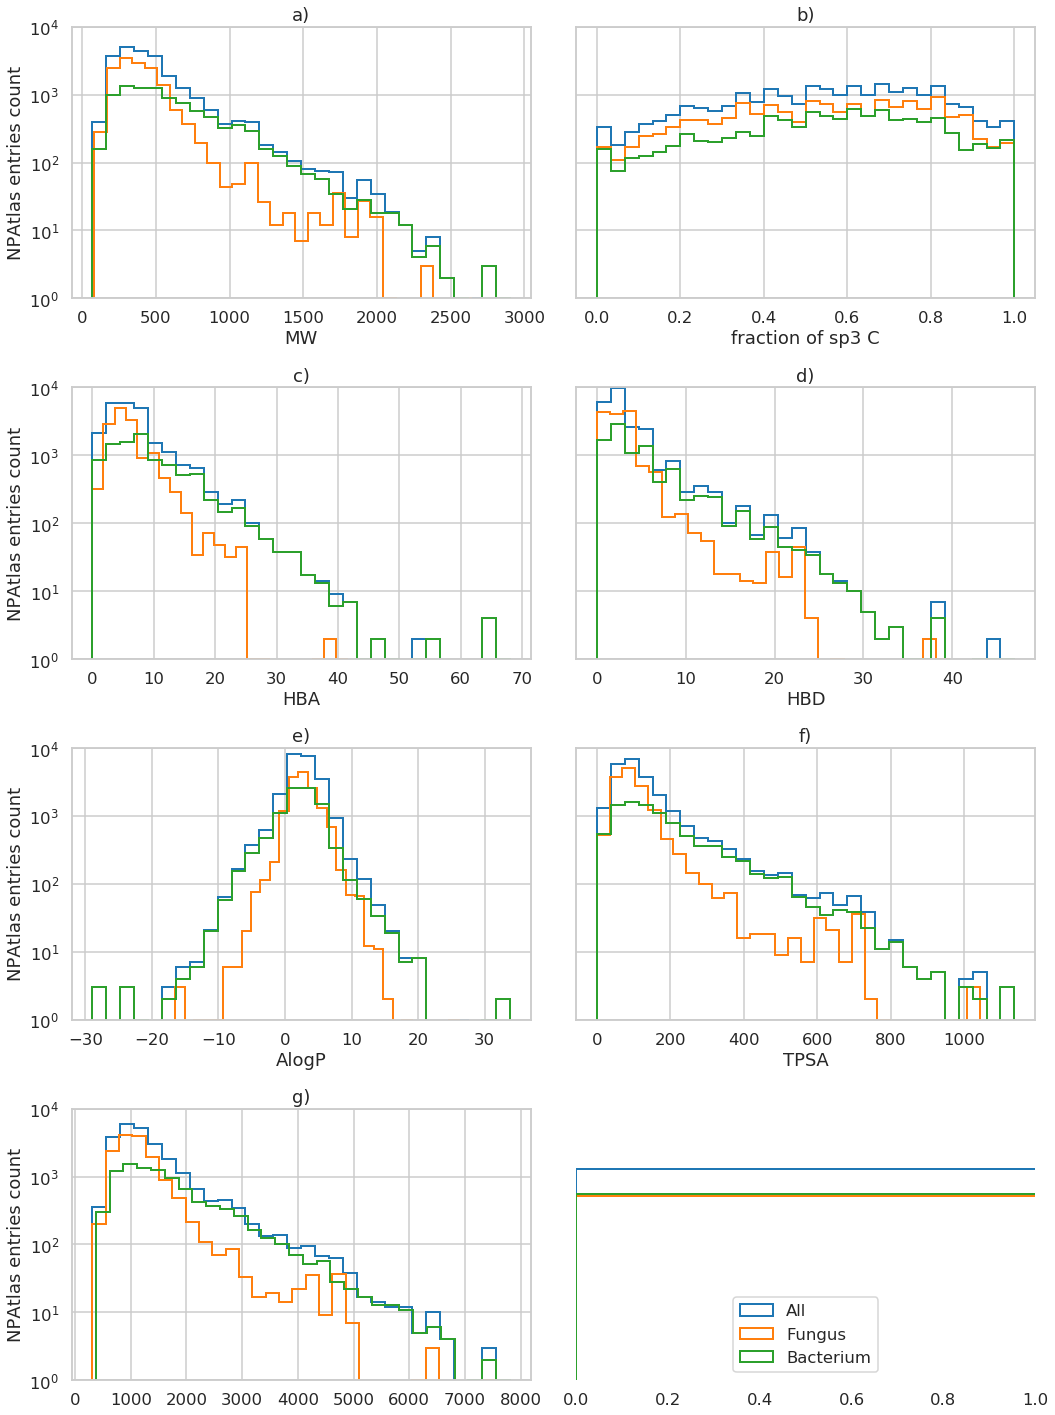

In [217]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk")
fig, axs = plt.subplots(4, 2, figsize =(15,20), sharey=True)
frame["MW"].hist(histtype="step",linewidth=2, label = "All", bins=30, log =True, ax=axs[0,0])
frame[frame["Origin"] == "Fungus"]["MW"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[0,0])
frame[frame["Origin"] == "Bacterium"]["MW"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[0,0])

frame["cLogP"].hist(histtype="step",linewidth=2, label = "All", bins=30, log =True, ax=axs[2,0])
frame[frame["Origin"] == "Fungus"]["cLogP"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[2,0])
frame[frame["Origin"] == "Bacterium"]["cLogP"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[2,0])

frame["boilingPoint"].hist(histtype="step",linewidth=2, label = "All", bins=30, log =True, ax=axs[3,0])
frame[frame["Origin"] == "Fungus"]["boilingPoint"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[3,0])
frame[frame["Origin"] == "Bacterium"]["boilingPoint"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[3,0])

frame["fcsp3"].hist(histtype="step",linewidth=2, label = "All", bins=30, ax=axs[0,1])
frame[frame["Origin"] == "Fungus"]["fcsp3"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[0,1])
frame[frame["Origin"] == "Bacterium"]["fcsp3"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[0,1])

frame["HBA"].hist(histtype="step",linewidth=2, label = "All", bins=30, ax=axs[1,0])
frame[frame["Origin"] == "Fungus"]["HBA"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[1,0])
frame[frame["Origin"] == "Bacterium"]["HBA"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[1,0])

frame["HBD"].hist(histtype="step",linewidth=2, label = "All", bins=30, ax=axs[1,1])
frame[frame["Origin"] == "Fungus"]["HBD"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[1,1])
frame[frame["Origin"] == "Bacterium"]["HBD"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[1,1])

frame["TPSA"].hist(histtype="step",linewidth=2, label = "All", bins=30, ax=axs[2,1])
frame[frame["Origin"] == "Fungus"]["TPSA"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[2,1])
frame[frame["Origin"] == "Bacterium"]["TPSA"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[2,1])

axs[0,0].set_ylabel("NPAtlas entries count")
axs[0,0].set_xlabel("MW")
axs[2,0].set_ylabel("NPAtlas entries count")
axs[2,0].set_xlabel("AlogP")
axs[1,0].set_xlabel("calculated boiling point")
axs[0,1].set_xlabel("fraction of sp3 C")
axs[1,0].set_ylabel("NPAtlas entries count")
axs[1,0].set_xlabel("HBA")
axs[1,1].set_xlabel("HBD")
axs[2,1].set_xlabel("TPSA")

axs[0,0].set_title("a)")
axs[0,1].set_title("b)")
axs[1,0].set_title("c)")
axs[1,1].set_title("d)")
axs[2,0].set_title("e)")
axs[2,1].set_title("f)")
axs[3,0].set_ylabel("NPAtlas entries count")
axs[3,0].set_title("g)")

plt.xlim(0,None)
plt.ylim(1,10000)

line1 = frame["TPSA"].hist(histtype="step",linewidth=2, label = "All", bins=30, ax=axs[3,1], alpha = 1)
line2 = frame[frame["Origin"] == "Fungus"]["TPSA"].hist(histtype="step",linewidth=2, label = "Fungus", bins= 30, log =True, ax=axs[3,1], alpha = 1)
line3 = frame[frame["Origin"] == "Bacterium"]["TPSA"].hist(histtype="step",linewidth=2, label = "Bacterium", bins=30, log =True, ax=axs[3,1], alpha = 1)


print(line1, line2, line3)
axs[3,1].grid(False)
#axs[1,3].set_xticks([])
#axs[1,3].set_yticks([])

plt.legend(loc="lower center")

axs[3,1].spines["right"].set_visible(False)
axs[3,1].spines["left"].set_visible(False)
axs[3,1].spines["top"].set_visible(False)
axs[3,1].spines["bottom"].set_visible(False)

plt.tight_layout()
plt.savefig("plots/all_prop.svg")

# 2. SVM and k-NN Classifiers
The dataset was assigned to training or test set with a 50% random split. A scikit-learn SVM and a k-NN classifiers with custom kernel were optimized using the training set to minimize the ROC AUC of the test set, using the MAP4 fingerprint as input. 

Other 2 SVM and two k-NN classifiers were implemented as described above but using only a specific subset of the training set during the training. For an SVM and a k-NN classifiers only the structures of the training set containing a dipeptide moiety were used. For the other SVM and k-NN classifiers only the structures of the training set containing an acetal moiety were used.

As a baseline for our analysis, we have used an SVM trained with physiochemical properties: fraction of sp3 carbon, HBA, HBD, ALogP, TPSA, MW, and calculated boiling point. 

For the evaluation of the classifiers we considered the class *bacterium* to be the positive class and the class *fungus* to be the negative one.

Please note that **when using MAP4 for machine learning a custom kernel (or a custom loss function) is needed** because the similarity/dissimilarity between two MinHashed fingerprints cannot be assessed with "standard" Jaccard, Manhattan, or Cosine functions. In fact, due to MinHashing, the order of the features matters and the distance cannot be calculated "feature-wise". There is a [well written blog post that explains it](https://aksakalli.github.io/2016/03/01/jaccard-similarity-with-minhash.html). 

> #### Custom Kernels 
>- The custom kernel implemented for the SVM models calculates the similarity matrix between two lists of MinHashed fingerprints; where the similarity of fingerprint *a* and fingerprint *b* is calculated (1) counting of elements with the same value and the same index across *a* and *b*, and (2) dividing the obtained value by the number of elements of fingerprint *a*. 
>- The custom kernel implemented for the k-NN classifiers calculates the distance between two MinHashed fingerprints as one minus the similarity between the two fingerprints calculated as in the SVM custom kernel. 

## MAP4 SVM Classifier

In [9]:
def norm_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    smiles_n = Chem.MolToSmiles(mol, isomericSmiles=False)
    return smiles_n

frame["norm_smiles"] = frame["SMILES"].map(norm_smiles) 

frame_tmap = frame.copy()
frame = frame.drop_duplicates(subset="norm_smiles")

frame["Set"] = "test"
frame_training = frame.sample(frac=0.50, random_state=12)
frame.loc[frame_training.index, 'Set'] = "training"

pd.to_pickle(frame, folder + "NPA_ML-with-prop.pkl")

In [5]:
frame = pd.read_pickle(folder + "NPA_ML-with-prop.pkl")

In [8]:
len(frame[frame["Origin"]=="Fungus"])

14596

In [9]:
len(frame[frame["Origin"]=="Bacterium"])

9332

In [10]:
len(frame)

23928

In [10]:
def train_clf(clf, X, Y, x, y):
    clf = clf.fit(X, Y)
    predicted_training = clf.predict_proba(X)
    predicted_test = clf.predict_proba(x)

    roc_training = roc_auc_score(Y, predicted_training[:,1])
    roc_test = roc_auc_score(y, predicted_test[:,1])

    print("ROC AUC Train: {:.3f}".format(roc_training))
    print("ROC AUC Test: {:.3f}".format(roc_test))
    return clf

def plt_roc_curve(clf, X, Y, x, y, name):
    predicted_training = clf.predict_proba(X)
    predicted_test = clf.predict_proba(x)
    fpr_test, tpr_test, _ = roc_curve(y, predicted_test[:,1])
    fpr_training, tpr_training, _ = roc_curve(Y, predicted_training[:,1])
    roc_training = roc_auc_score(Y, predicted_training[:,1])
    roc_test = roc_auc_score(y, predicted_test[:,1])
    
    plt.figure(figsize = (5, 4))
       
    plt.rcParams.update({'font.size': 15})
    lw = 2
    plt.plot(fpr_training, tpr_training, color='blue',
             lw=lw, label='Training Set ROC AUC = %0.2f' % roc_training)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='Test Set ROC AUC = %0.2f' % roc_test)
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
    plt.xlim([-0.005, 1.0])
    plt.ylim([-0.005, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    #plt.title(name)
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.savefig("plots/{}.svg".format(name))
    plt.show()
    
def correct_pred(row):
    if row.isPredBacterium == 2:
        return 2
    else:
        if row.isPredBacterium == row.isBacterium:
            return 1
        else:
            return 0

#### Custom kernel for SVM and k-NN Classifiers
Please note that the similarity/dissimilarity between two MinHashed fingerprints cannot be assessed with "standard" Jaccard, Manhattan, or Cosine functions. Due to MinHashing, the order of the features matters and the distance cannot be calculated "feature-wise". There is a well written blog post that explains it: https://aksakalli.github.io/2016/03/01/jaccard-similarity-with-minhash.html. Therefore, a custom kernel needs to be implemented.

In [11]:
def map4_kernel_SVM(a, b=None):
    if b is None:
        b=a
    JS_all_pairs = np.zeros((len(a),len(b)))
    for i,fp1 in enumerate(a):
        for j,fp2 in enumerate(b):
            JS_all_pairs[i,j] = np.float(np.count_nonzero(fp1 == fp2)) / np.float(len(fp1))
    return JS_all_pairs

def map4_kernel_NN(fp1, fp2):
    return 1- np.float(np.count_nonzero(fp1 == fp2)) / np.float(len(fp1))

In [12]:
# preparing features for training (X) and test (x)
X = np.array(frame[frame["Set"] == "training"].MAP4.to_list())
x = np.array(frame[frame["Set"] == "test"].MAP4.to_list())
# generate prediction for training (Y) and test(y) sets
Y = frame[frame["Set"] == "training"].isBacterium.values
y = frame[frame["Set"] == "test"].isBacterium.values
Y = np.array(Y, dtype=np.float)
y = np.array(y, dtype=np.float)

base_clf = make_pipeline(svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))
if not os.path.exists(folder+"SVM-NPA.pkl"):
    # SVM optimization for ROC auc
    param_grid = {'svc__C': [0.1,1, 10, 100, 1000], \
                  'svc__kernel': [map4_kernel_SVM]}
    grid = GridSearchCV(base_clf, param_grid, scoring='roc_auc',\
                        refit=True,verbose=2, n_jobs=7)
    grid.fit(X,Y)
    print(grid.best_estimator_)
    
    joblib.dump(grid, folder + "SVM-NPA.pkl")
else:
    grid = joblib.load(folder + "SVM-NPA.pkl")

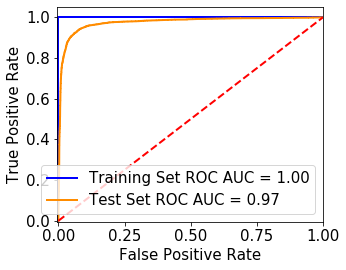

In [13]:
plt_roc_curve(grid, X, Y, x, y, "SVM_Jaccard_kernel")

In [14]:
pred = grid.predict(x)
print("balanced accuracy: " + str(metrics.balanced_accuracy_score(y, pred)))
print("mcc: " + str(metrics.matthews_corrcoef(y, pred)))
print("f1 score: " + str(metrics.f1_score(y, pred)))

balanced accuracy: 0.9273295547884107
mcc: 0.8605053611718695
f1 score: 0.9133633468760294


balanced accuracy: 0.9273295547884107
mcc: 0.8605053611718695
f1 score: 0.9133633468760294

In [15]:
# SVM prediction for TMAP
frame["isPredBacterium"] = 2
indices = frame[frame["Set"] == "test"].index
frame.loc[indices, "isPredBacterium"] = pred
frame["isPredBacterium"] = frame["isPredBacterium"].map(int)
frame["isPredCorrect"] = frame.apply(correct_pred, axis=1)

frame_tmap['Set'] = np.nan
frame_tmap['isPredBacterium'] = np.nan 
frame_tmap['isPredCorrect'] = np.nan
frame_tmap.Set = frame.Set
frame_tmap.isPredBacterium = frame.isPredBacterium
frame_tmap.isPredCorrect = frame.isPredCorrect

frame_tmap["Set"] = frame_tmap.groupby("norm_smiles", sort=False)["Set"].apply(lambda x: x.ffill().bfill())
frame_tmap["isPredBacterium"] = frame_tmap.groupby("norm_smiles", sort=False)["isPredBacterium"].apply(lambda x: x.ffill().bfill())
frame_tmap["isPredCorrect"] = frame_tmap.groupby("norm_smiles", sort=False)["isPredCorrect"].apply(lambda x: x.ffill().bfill())

frame_tmap = frame_tmap.astype({"isPredBacterium":"int", "isPredCorrect":"int"})

frame_tmap.to_pickle(folder + "NPA-with-prop-duplicatesfilled.pkl")

## MAP4 k-NN Classifier

In [16]:
base_clf_NN = KNeighborsClassifier(algorithm='brute', metric=map4_kernel_NN, n_jobs=7)

if not os.path.exists(folder+"NN-NPA.pkl"):
    # NN optimization for ROC auc
    param_grid = {'n_neighbors': [5,7,9,11]}
    grid_NN = GridSearchCV(base_clf_NN, param_grid, scoring='roc_auc',\
                        refit=True,verbose=2)
    grid_NN.fit(X,Y)
    print(grid_NN.best_estimator_)
    
    joblib.dump(grid_NN, folder + "NN-NPA.pkl")
else:
    grid_NN = joblib.load(folder + "NN-NPA.pkl")

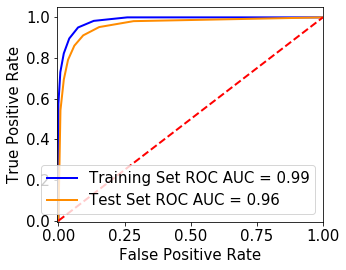

In [17]:
plt_roc_curve(grid_NN, X, Y, x, y, "NN_Jaccard_kernel")

In [18]:
pred_NN = grid_NN.predict(x)
print("balanced accuracy: " + str(metrics.balanced_accuracy_score(y, pred_NN)))
print("mcc: " + str(metrics.matthews_corrcoef(y, pred_NN)))
print("f1 score: " + str(metrics.f1_score(y, pred_NN)))

balanced accuracy: 0.9002556288091872
mcc: 0.8075372919365679
f1 score: 0.8800882515168228


balanced accuracy: 0.9002556288091872
mcc: 0.8075372919365679
f1 score: 0.8800882515168228

## SVM Classifier Peptides

In [19]:
# preparing features for training (X) and test (x)
X_pep = np.array(frame.query('isPeptide==1 and Set == "training"').MAP4.to_list())
x_pep = np.array(frame.query('isPeptide==1 and  Set == "test"').MAP4.to_list())
# generate prediction for training (Y) and test(y) sets
Y_pep = frame.query('isPeptide==1 and Set == "training"').isBacterium.values
y_pep = frame.query('isPeptide==1 and Set == "test"').isBacterium.values
Y_pep = np.array(Y_pep, dtype=np.float)
y_pep = np.array(y_pep, dtype=np.float)

base_clf_pep = make_pipeline(svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))

In [20]:
if not os.path.exists(folder+"SVM-NPA-pep.pkl"):
    # SVM optimization for ROC auc
    param_grid = {'svc__C': [0.1,1, 10, 100, 1000], \
                  'svc__kernel': [map4_kernel_SVM]}
    grid_pep = GridSearchCV(base_clf_pep, param_grid, scoring='roc_auc',\
                        refit=True,verbose=2, n_jobs=7)
    grid_pep.fit(X_pep,Y_pep)
    print(grid_pep.best_estimator_)
    
    joblib.dump(grid_pep, folder + "SVM-NPA-pep.pkl")
else:
    grid_pep = joblib.load(folder + "SVM-NPA-pep.pkl")

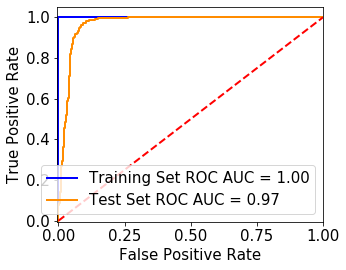

In [21]:
plt_roc_curve(grid_pep, X_pep, Y_pep, x_pep, y_pep, "SVM_Jaccard_kernel_pep")

In [22]:
pred_pep = grid_pep.predict(x_pep)
print("balanced accuracy: " + str(metrics.balanced_accuracy_score(y_pep, pred_pep)))
print("mcc: " + str(metrics.matthews_corrcoef(y_pep, pred_pep)))
print("f1 score: " + str(metrics.f1_score(y_pep, pred_pep)))

balanced accuracy: 0.9254224383534728
mcc: 0.8901517816130338
f1 score: 0.973251994368841


balanced accuracy: 0.9254224383534728
mcc: 0.8901517816130338
f1 score: 0.973251994368841

## k-NN Classifier Peptides

In [23]:
base_clf_NN_pep = KNeighborsClassifier(algorithm='brute', metric=map4_kernel_NN, n_jobs=7)

if not os.path.exists(folder+"NN-NPA-pep.pkl"):
    # NN optimization for ROC auc
    param_grid = {'n_neighbors': [5,7,9,11]}
    grid_NN_pep = GridSearchCV(base_clf_NN_pep, param_grid, scoring='roc_auc',\
                        refit=True,verbose=2)
    grid_NN_pep.fit(X,Y)
    print(grid_NN_pep.best_estimator_)
    
    joblib.dump(grid_NN_pep, folder + "NN-NPA-pep.pkl")
else:
    grid_NN_pep = joblib.load(folder + "NN-NPA-pep.pkl")

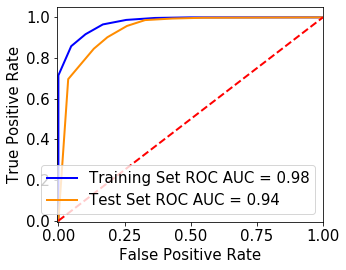

In [24]:
plt_roc_curve(grid_NN_pep, X_pep, Y_pep, x_pep, y_pep, "NN_Jaccard_kernel_pep")

In [25]:
pred_NN_pep = grid_NN.predict(x_pep)
print("balanced accuracy: " + str(metrics.balanced_accuracy_score(y_pep, pred_NN_pep)))
print("mcc: " + str(metrics.matthews_corrcoef(y_pep, pred_NN_pep)))
print("f1 score: " + str(metrics.f1_score(y_pep, pred_NN_pep)))

balanced accuracy: 0.8492975734355044
mcc: 0.7343112886938606
f1 score: 0.9367681498829038


balanced accuracy: 0.8492975734355044
mcc: 0.7343112886938606
f1 score: 0.9367681498829038

## SVM Classifier Sugars

In [26]:
# preparing features for training (X) and test (x)
X_sugar = np.array(frame.query('hasSugar==1 and Set == "training"').MAP4.to_list())
x_sugar = np.array(frame.query('hasSugar==1 and  Set == "test"').MAP4.to_list())
# generate prediction for training (Y) and test(y) sets
Y_sugar = frame.query('hasSugar==1 and Set == "training"').isBacterium.values
y_sugar = frame.query('hasSugar==1 and Set == "test"').isBacterium.values
Y_sugar = np.array(Y_sugar, dtype=np.float)
y_sugar = np.array(y_sugar, dtype=np.float)

base_clf_sugar = make_pipeline(svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))

In [27]:
if not os.path.exists(folder+"SVM-NPA-sugar.pkl"):
    # SVM optimization for ROC auc
    param_grid = {'svc__C': [0.1,1, 10, 100, 1000], \
                  'svc__kernel': [map4_kernel_SVM]}
    grid_sugar = GridSearchCV(base_clf_sugar, param_grid, scoring='roc_auc',\
                        refit=True,verbose=2, n_jobs=7)
    grid_sugar.fit(X_sugar,Y_sugar)
    print(grid_sugar.best_estimator_)
    
    joblib.dump(grid_sugar, folder + "SVM-NPA-sugar.pkl")
else:
    grid_sugar = joblib.load(folder + "SVM-NPA-sugar.pkl")

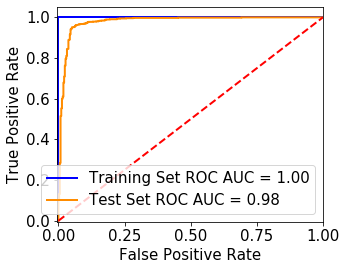

In [28]:
plt_roc_curve(grid_sugar, X_sugar, Y_sugar, x_sugar, y_sugar, "SVM_Jaccard_kernel_sugar")

In [29]:
pred_sugar = grid_sugar.predict(x_sugar)
print("balanced accuracy: " + str(metrics.balanced_accuracy_score(y_sugar, pred_sugar)))
print("mcc: " + str(metrics.matthews_corrcoef(y_sugar, pred_sugar)))
print("f1 score: " + str(metrics.f1_score(y_sugar, pred_sugar)))

balanced accuracy: 0.9404594946967828
mcc: 0.8853412981290637
f1 score: 0.963011031797534


balanced accuracy: 0.9404594946967828
mcc: 0.8853412981290637
f1 score: 0.963011031797534

## k-NN Classifier Sugars

In [30]:
def map4_kernel_NN(fp1, fp2):
    return 1-(np.float(np.count_nonzero(fp1 == fp2)) / np.float(len(fp1)))

base_clf_NN_sugars = KNeighborsClassifier(algorithm='brute', metric=map4_kernel_NN, n_jobs=7)

if not os.path.exists(folder+"NN-NPA-sugars.pkl"):
    # NN optimization for ROC auc
    param_grid = {'n_neighbors': [5,7,9,11]}
    grid_NN_sugars = GridSearchCV(base_clf_NN_sugars, param_grid, scoring='roc_auc',\
                        refit=True,verbose=2)
    grid_NN_sugars.fit(X,Y)
    print(grid_NN_sugars.best_estimator_)
    
    joblib.dump(grid_NN_sugars, folder + "NN-NPA-sugars.pkl")
else:
    grid_NN_sugars = joblib.load(folder + "NN-NPA-sugars.pkl")

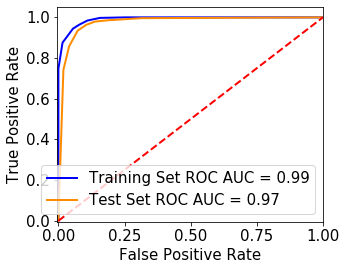

In [31]:
plt_roc_curve(grid_NN_sugars, X_sugar, Y_sugar, x_sugar, y_sugar, "NN_Jaccard_kernel_sugars")

In [32]:
pred_NN_sugars = grid_NN_sugars.predict(x_sugar)
print("balanced accuracy: " + str(metrics.balanced_accuracy_score(y_sugar, pred_NN_sugars)))
print("mcc: " + str(metrics.matthews_corrcoef(y_sugar, pred_NN_sugars)))
print("f1 score: " + str(metrics.f1_score(y_sugar, pred_NN_sugars)))

balanced accuracy: 0.9290443637901264
mcc: 0.8649554073521083
f1 score: 0.9566343042071198


balanced accuracy: 0.9095096278295782;
mcc: 0.8177620104079666;
f1 score: 0.9349904397705545.

## SVM properties

In [33]:
# preparing features for training (X) and test (x)
features = ['fcsp3', 'HBA', 'HBD', 'cLogP', 'TPSA',  'MW', 'boilingPoint']
X_prop = np.array(frame[frame["Set"] == "training"][features].values)
x_prop = np.array(frame[frame["Set"] == "test"][features].values)
# generate prediction for training (Y) and test(y) sets
Y = frame[frame["Set"] == "training"].isBacterium.values
y = frame[frame["Set"] == "test"].isBacterium.values
Y = np.array(Y, dtype=np.float)
y = np.array(y, dtype=np.float)

from sklearn.preprocessing import StandardScaler 

base_clf = make_pipeline(StandardScaler(), svm.SVC(probability=True, class_weight="balanced", cache_size=1900, random_state=12))
if not os.path.exists(folder+"SVM-NPA-prop.pkl"):
    # SVM optimization for ROC auc
    param_grid = {'svc__C': [0.1, 1, 10, 100, 1000], 'svc__gamma': [0.01, 0.1, 1, 10, 100],\
                  'svc__kernel': ["rbf"]}
    grid_prop = GridSearchCV(base_clf, param_grid, scoring='roc_auc',\
                        refit=True,verbose=2, n_jobs=7)
    grid_prop.fit(X_prop,Y)
    print(grid_prop.best_estimator_)
    
    joblib.dump(grid_prop, folder + "SVM-NPA-prop.pkl")
else:
    grid_prop = joblib.load(folder + "SVM-NPA-prop.pkl")

In [59]:
grid_prop = joblib.load(folder + "SVM-NPA-prop.pkl")

In [61]:
grid_prop.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=10, break_ties=False, cache_size=1900,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=1,
                     kernel='rbf', max_iter=-1, probability=True,
                     random_state=12, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

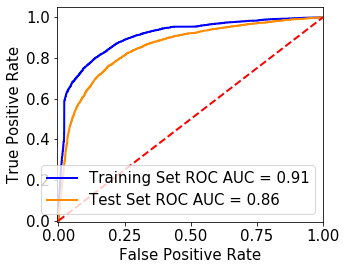

In [34]:
plt_roc_curve(grid_prop, X_prop, Y, x_prop, y, "SVM_properties")

In [35]:
pred_SVM_prop = grid_prop.predict(x_prop)
print("balanced accuracy: " + str(metrics.balanced_accuracy_score(y, pred_SVM_prop)))
print("mcc: " + str(metrics.matthews_corrcoef(y, pred_SVM_prop)))
print("f1 score: " + str(metrics.f1_score(y, pred_SVM_prop)))

balanced accuracy: 0.7809887002822133
mcc: 0.5634208175166292
f1 score: 0.7313416621401413


# 3. The Natural Product Atlas MAP4 TMAP
Using the indices generated by the MinHashing procedure of the MAP4 calculation, an LSH forest was generated and used to layout the [TMAP](https://github.com/reymond-group/tmap).
The resulting TMAP can be found [here](https://tm.gdb.tools/map4/npatlas_map_tmap/).

- the LSH forest is generated

In [11]:
if not os.path.exists(folder+"NPA_LSHforest"):
    fps = frame_tmap["MAP4"].tolist()
    fps_ = []

    for fp in fps:
        fp_ = tm.VectorUint(fp)
        fps_.append(fp_)

    lf = tm.LSHForest(1024, 32)
    lf.batch_add(fps_)

    lf.index()
    lf.store(folder + 'NPA_LSHforest')
else:
    lf = tm.LSHForest(1024, 32)
    lf.restore(folder + 'NPA_LSHforest')

In [43]:
frame_tmap = pd.read_pickle(folder + "NPA-with-prop-duplicatesfilled.pkl")

In [44]:
fps = frame_tmap["MAP4"].tolist()

In [168]:
distances = []
for fp in fps:
    fp_ = tm.VectorUint(fp)
    distances.append(lf.get_all_distances(fp_))

In [188]:
new_distances = []
k = 21 #we remove the 21st because it is itself 
for array in distances:
    first_twenty = np.array(array)
    idx = np.argpartition(first_twenty,k)[:k]
    values = np.sort(first_twenty[idx])[1:]
    new_distances.append(values)
    

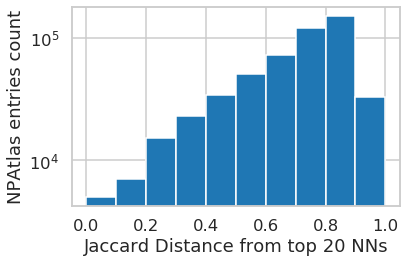

In [214]:
plt.hist(new_distances_20nn.flatten(), log=True, bins=10)
plt.ylabel("NPAtlas entries count")
plt.xlabel("Jaccard Distance from top 20 NNs")
plt.tight_layout()
plt.savefig("plots/20NN")

- the TMAP layout is estrapolated from the LSH forest

In [25]:
if not os.path.exists(folder+"tm_layout.pkl"):
    cfg = tm.LayoutConfiguration()

    # config
    cfg.node_size = 1 / 25
    cfg.mmm_repeats = 2
    cfg.sl_extra_scaling_steps = 5
    cfg.k = 20
    cfg.sl_scaling_type = tm.RelativeToAvgLength
    # Compute the layout

    x_, y_, s, t, gp = tm.layout_from_lsh_forest(lf, cfg)
    tm_layout = {"x": list(x_), "y": list(y_), "s" : list(s), "t" : list(t)}
    joblib.dump(tm_layout, folder+"tm_layout.pkl")
else:
    tm_layout = joblib.load(folder+"tm_layout.pkl")

- Properties, labels and SMILES are prepared
(Some properties are bound to a minimum and maximum values for a better visualization, all continuos properties are also shown ranked)

In [26]:
tmp = frame_tmap.copy()
idx = tmp[tmp.boilingPoint >= 2000].index
tmp.loc[idx, "boilingPoint"]=2000

idx = tmp[tmp["MW"] >= 1000].index
tmp.loc[idx, "MW"] = 1000

idx = tmp[tmp.HBA >= 20].index
tmp.loc[idx, "HBA"] = 20

idx = tmp[tmp.HBD >= 10].index
tmp.loc[idx, "HBD"] = 10

idx = tmp[tmp.cLogP >= 8].index
tmp.loc[idx, "cLogP"] = 8

idx = tmp[tmp.cLogP <= -2].index
tmp.loc[idx, "cLogP"] = -2

idx = tmp[tmp.TPSA >= 500].index
tmp.loc[idx, "TPSA"]= 500

MW = tmp.MW.tolist()
MW_r = rankdata(frame_tmap.MW.tolist())

fcsp3 = frame_tmap.fcsp3.tolist()
fcsp3_r = rankdata(fcsp3)

HBA = tmp.HBA.tolist()
HBA_r = rankdata(frame_tmap.HBA.tolist())

HBD = tmp.HBD.tolist()
HBD_r = rankdata(frame_tmap.HBD.tolist())

clogp = tmp.cLogP.tolist()
clogp_r = rankdata(frame_tmap.cLogP.tolist())

tpsa = tmp.TPSA.tolist()
tpsa_r = rankdata(frame_tmap.TPSA.tolist())

boilingPoint = tmp.boilingPoint.tolist()
boiling_r = rankdata(frame_tmap.boilingPoint.tolist())

isLipinski = frame_tmap.isLipinski.tolist()
isBacterium = frame_tmap.isBacterium.tolist()

isPredBacterium = frame_tmap.isPredBacterium.tolist()
isPredCorrect = frame_tmap.isPredCorrect.tolist()
isPeptide = frame_tmap.isPeptide.tolist()
hasSugar = frame_tmap.hasSugar.tolist()
Substructure = frame_tmap.substructure.tolist()

labels = frame_tmap.TMAPlabel.tolist()
SMILES = frame_tmap.SMILES.tolist()
NPAID = frame_tmap.NPAID.tolist()

The color maps and the labels for categorical properties are generated

In [27]:
custom_cmap = ListedColormap([ 'magenta', 'limegreen', 'lightgray'], name="custom")
custom_cmap2 = ListedColormap([ 'magenta', 'limegreen', 'yellow', 'gray'], name="custom2")

groups = ["0 - No", "1 - Yes"]
labels_groups, groups = Faerun.create_categories(groups)

groups2 = ["0 - Fungus", "1 - Bacterium"]
labels_groups2, groups2 = Faerun.create_categories(groups2)

groups3 = ["0 - Test set predicted Fungus", "1 - Test set predicted Bacterium", "2 - Training set"]
labels_groups3, groups3 = Faerun.create_categories(groups3)

groups4 = ["0 - Wrong prediction (test set)", "1 - Correct prediction (test set)", "2 - Training set"]
labels_groups4, groups4 = Faerun.create_categories(groups4)

groups5 = ["0 - Contains sugar moiety", "1 - Contains dipeptide moiety", "2 - Contains acetal and dipeptide moieties", "3 - Does not contains acetal or dipeptide moieties"]
labels_groups5, groups5 = Faerun.create_categories(groups5)

Faerun is used to plot the TMAP

In [30]:
faerun = Faerun(view="front", coords=False, title='MAP4_NaturalProductsAtlas')#, clear_color="#ffffff",)
faerun.add_scatter("NP_Atlas",{"x": tm.VectorFloat(tm_layout["x"]), "y": tm.VectorFloat(tm_layout["y"]), "c": [MW, fcsp3, HBA, HBD, clogp, tpsa, boilingPoint, \
                                                     MW_r, fcsp3_r, HBA_r, HBD_r, clogp_r, tpsa_r, boiling_r, isBacterium, isPredBacterium, isPredCorrect, isLipinski, Substructure],\
                          "labels": labels}, has_legend=True, \
    colormap=["rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", \
              "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", "rainbow", custom_cmap, custom_cmap, custom_cmap, custom_cmap, custom_cmap2], \
        point_scale=2.5, categorical=[False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, True, True],\
        series_title=["MW", "Fraction sp3 C", "HBA count", "HBD count", "AlogP", "TPSA", "Calculated boiling point (K)",\
                      "MW rank", "Fraction sp3 C  rank", "HBA count  rank", "HBD count rank", "AlogP rank", "TPSA rank", "Calculated boiling point (K) rank", \
                      "Origin", "MAP4 SVM prediction", "MAP4 SVM performance", "is Lipinski", "SMARTS substructures"], \
            max_legend_label=[">=1000", str(round(max(fcsp3),2)), ">=20",\
                              ">=10", ">=8", ">=500", ">=2000",\
                              str(round(max(MW_r),2)), str(round(max(fcsp3_r),2)), str(round(max(HBA_r),2)),\
                              str(round(max(HBD_r),2)), str(round(max(clogp_r),2)), str(round(max(tpsa_r),2)), str(round(max(boiling_r),2)), None, None, None, None, None],\
                   min_legend_label=[str(round(min(MW),2)), str(round(min(fcsp3),2)), str(round(min(HBA),2)),\
                              str(round(min(HBD),2)), "<=-2", str(round(min(tpsa),2)), str(round(min(boilingPoint),2)), \
                                     str(round(min(MW_r),2)), str(round(min(fcsp3_r),2)), str(round(min(HBA_r),2)),\
                              str(round(min(HBD_r),2)), str(round(min(clogp_r),2)), str(round(min(tpsa_r),2)), str(round(min(boiling_r),2)), None, None, None, None, None],\
                    legend_labels=[None, None, None, None, None, None, None, None, None, None, None, None, None, None, labels_groups2, labels_groups3, labels_groups4, labels_groups,\
                                   labels_groups5])



faerun.add_tree("NP_Atlas_tree",{"from": tm.VectorUint(tm_layout["s"]), "to": tm.VectorUint(tm_layout["t"])}, point_helper="NP_Atlas", color="aaaaaa")
faerun.plot('MAP4_NaturalProductsAtlas', template = 'smiles')

/home/alice/Code/NPAtlas-Clean/MAP4_NaturalProductsAtlas.html